In [4]:
#!{sys.executable} -m pip install matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from collections import OrderedDict

In [2]:
def filter_df(df_orig, col, arg, op='=='):
    df = df_orig.copy()
    
    if op == '==':
        df = df.loc[df[col]==arg]
    elif op == '<':
        df = df.loc[df[col]<arg]
    elif op == '>':
        df = df.loc[df[col]>arg]
    elif op == '<=':
        df = df.loc[df[col]<=arg]
    elif op == '>=':
        df = df.loc[df[col]>=arg]
    elif op == '!=':
        df = df.loc[df[col]!=arg]
    elif op == 'isin':
        assert(type(arg) is list)
        df = df.loc[df[col].isin(arg)]
    else:
        print('op type not supported!')
        assert(1==0)
    
    return df

def get_path(path_string):
    path_list = [int(node_id) for node_id in path_string.split(sep=';')[2:]]
    return path_list

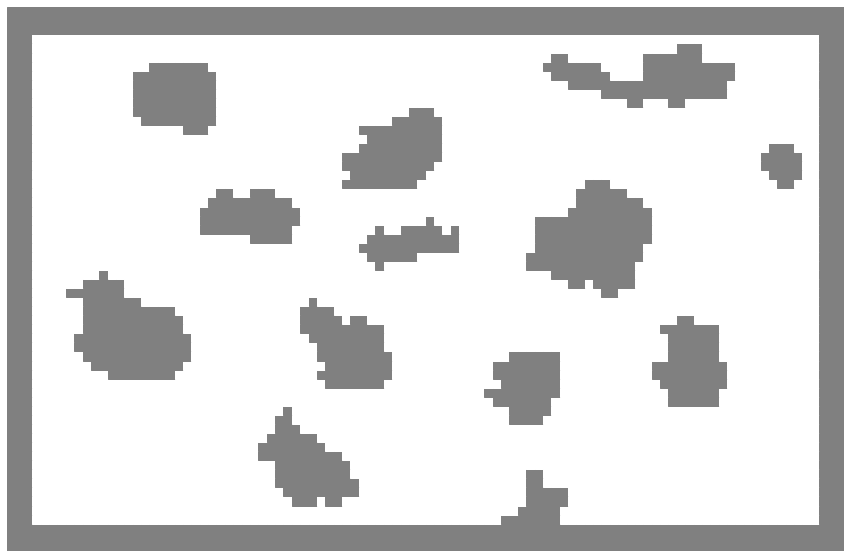

In [3]:
config_df = pd.read_csv("../cmake-build-debug/config_log.txt", sep=",", header=0)
config_dict = config_df.iloc[0,:].to_dict()


fig, ax = fig, ax = plt.subplots(1, figsize=(15,10))

padding=0
ax.set_xlim(0-padding, 100+padding)
ax.set_ylim(0-padding, 60+padding)

ax.axis('off')

# Add obstacles
if (config_dict['use_occupancy_grid'] == 0):
    if config_dict['obstacle_cost'] > 0:
        for obstacle_nr in range(0,4):
            obst_id_rad = 'obstacle_rad_'+str(obstacle_nr)
            obst_id_x = 'obstacle_pos_'+str(obstacle_nr)+'_x'
            obst_id_y = 'obstacle_pos_'+str(obstacle_nr)+'_y'

            ellipse_plot_0 = patches.Circle((config_dict[obst_id_x],config_dict[obst_id_y]), 
                                     radius=config_dict[obst_id_rad], color='gray')

            ax.add_patch(ellipse_plot_0)
else:
    grid = pd.read_csv(config_dict['grid_path'], header=None).to_numpy()

    for row in range(0, grid.shape[0]):
        for column in range(0, grid.shape[1]):
            if (grid[59-row, column] == 0):
                color='w'
            else:
                color='gray'

            grid_cell = patches.Rectangle((column, row),1,1, color=color)

            ax.add_patch(grid_cell)

fig.savefig('rendered_grid.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches='tight', pad_inches=0,
        metadata=None)

In [16]:
class Metrics():
    def __init__(self, sim_df, config_dict):
        self.sim_df = sim_df
        self.config_dict = config_dict
        
        self.rmse = 0;
        self.t90 = 0;
        self.rmse_t90 = 0;
        
        self.calc_metrics()
        self.build_log_df()
    
    def calc_metrics(self):
        self.rmse = round(self.sim_df[['distance_to_target']].mean()[0],ndigits=4);
        t90_df = filter_df(self.sim_df, 'distance_to_target', self.sim_df.loc[0,'distance_to_target']*0.1, '<=')
        self.t90 = t90_df.head(n=1)['simstep'].to_numpy()[0]
        self.rmse_t90 = round(t90_df[['distance_to_target']].mean()[0],ndigits=4);
        
    def build_log_df(self):
        
        log_df = pd.DataFrame()
        log_dict = OrderedDict(config_dict, **{'RMSE': self.rmse, 't-90': self.t90, 'RMSE_t-90': self.rmse_t90}); 
        # log_dict.update(metrics_dict)

        log_df = log_df.append(log_dict,ignore_index=True)

        cols = ['sim_time', 'horizon', 'rollouts', 'pruning_threshold', 'use_last_best', 'use_cum_cost', 'use_cum_cost_for_imp_sampling', 'use_imp_sampling', 'RMSE', 'RMSE_t-90', 't-90' ]

        self.log_df = log_df[cols]
        
    def save_metrics(self):
        filename = config_dict['note_filename']+'.csv'
        
        try:
            input_df = pd.read_csv(filename)
            print('extending existing df')
            print('input_length',input_df.shape[0])
        except:
            input_df = pd.DataFrame()
            print('creating new df')
        
        self.output_df = input_df.append(self.log_df, ignore_index=True)
        
        self.output_df.to_csv(path_or_buf=filename, index=False)
        print('successfully saved', filename)
        
        
        
        


In [19]:
config_df = pd.read_csv("../cmake-build-debug/config_log.txt", sep=",", header=0)
display(config_df)
config_dict = config_df.iloc[0,:].to_dict()

sim_df = pd.read_csv("../cmake-build-debug/sim_log.txt", sep=",", header=0)
display(sim_df.head())

sampling_df = pd.read_csv("../cmake-build-debug/sampling_log.txt", sep=",", header=0)
display(sampling_df)

Metrician = Metrics(sim_df, config_dict)

,sim_time,rollouts,horizon,obstacle_cost,use_occupancy_grid,grid_path,start_state_0,start_state_1,target_state_0,target_state_1,use_cum_cost,use_last_best,pruning_threshold,use_imp_sampling,use_cum_cost_for_imp_sampling,note_filename,Unnamed: 16
0,200,20,30,10000,1,/home/etienne/git_clone/FDMCTree/grid_python/6...,5,5,87,38,1,1,0.5,1,1,mtc_,NaN


,simstep,state_0,state_1,state_2,state_3,state_4,state_5,distance_to_target,Unnamed: 8
0,0,5.00000,5.00000,0.000000,0.000000,0.000000,0.000000,88.3912,NaN
1,1,5.02756,5.04761,0.055121,0.095217,0.055121,0.095217,88.3478,NaN
2,2,5.15650,5.08280,0.202758,-0.024838,0.147637,-0.120055,88.2151,NaN
3,3,5.39746,5.13699,0.279164,0.133213,0.076406,0.158051,87.9713,NaN
4,4,5.66081,5.25394,0.247542,0.100701,-0.031622,-0.032512,87.6833,NaN


,node_id,simstep,step,rollout,state_0,state_1,state_2,state_3,state_4,state_5,cost_cum,path_to_leaf,Unnamed: 12
0,22,0,0,0,4.90557,4.97882,-0.188859,-0.042354,-0.188859,-0.042354,176.8780,0;0;1;22,NaN
1,23,0,0,1,5.05015,4.98499,0.100294,-0.030020,0.100294,-0.030020,176.7410,0;0;2;23,NaN
2,24,0,0,2,4.95614,5.02543,-0.087713,0.050866,-0.087713,0.050866,176.8140,0;0;3;24,NaN
3,25,0,0,3,4.85161,4.93970,-0.296778,-0.120609,-0.296778,-0.120609,176.9430,0;0;4;25,NaN
4,26,0,0,4,4.91644,5.04187,-0.167110,0.083745,-0.167110,0.083745,176.8440,0;0;5;26,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,120017,199,29,15,88.16680,35.58830,0.139248,0.116482,0.170893,0.258975,18.1424,0;0;1;119422;119444;119463;119498;119510;11953...,NaN
119996,120018,199,29,16,88.69330,35.69450,0.399580,-0.064098,0.193187,0.180063,17.8579,0;0;1;119422;119444;119463;119498;119510;11953...,NaN
119997,120019,199,29,17,86.93360,36.05760,-0.059834,-0.142618,-0.015650,-0.057098,15.2039,0;0;1;119422;119444;119463;119498;119510;11953...,NaN
119998,120020,199,29,18,84.24370,37.89460,-0.347537,-0.276562,-0.066489,0.035054,19.3425,0;0;1;119422;119444;119463;119498;119510;11953...,NaN


In [20]:
def draw_interactive(simstep, step):
    
    img = plt.imread("rendered_grid.png")
    
    fig, ax = fig, ax = plt.subplots(1, figsize=(15,10))
    
    ax.imshow(img, extent=[0, 100, 0, 60])

    padding=2
    ax.set_xlim(0-padding, 100+padding)
    ax.set_ylim(0-padding, 60+padding)
    
    # filter data down to relevant data
    df_timestep = filter_df(sampling_df, "simstep", simstep, op='==')
    df_timestep = filter_df(df_timestep, "step", step, op='==')

    # plot start and target position
    ax.scatter(config_df.loc[0,'start_state_0'], config_df.loc[0,'start_state_1'], s=60, marker='o', c='k',zorder=20)
    ax.scatter(config_df.loc[0,'target_state_0'], config_df.loc[0,'target_state_1'], s=60, marker='x', c='k',zorder=20)
    
    # plot path of different rollouts
    for idx, row in df_timestep.iterrows():
        path = get_path(row['path_to_leaf'])
        df_path = filter_df(sampling_df, "node_id", path, op='isin')
        
        ax.plot(df_path[['state_0']], df_path[['state_1']], zorder=10)
    
       
    # plot robot, actual and planned path
    #ax.plot(sim_df[['state_0']], sim_df[['state_1']], c='k', alpha=0.3)
    ax.plot(sim_df[['state_0']][:simstep+1], sim_df[['state_1']][:simstep+1], c='r')
    ax.scatter(sim_df[['state_0']].iloc[simstep], sim_df[['state_1']].iloc[simstep],s=50, marker='D', c='r',zorder=20)
    
    padding=2
    ax.set_xlim(0-padding, 100+padding)
    ax.set_ylim(0-padding, 60+padding)
    
    
    fig2, ax2 = plt.subplots(2,1, figsize=(15,5))
    
    ax2[0].plot(sim_df[['simstep']] , sim_df[['distance_to_target']], c='k')
    ax2[0].grid()
    ax2[0].fill_between(sim_df[['simstep']].to_numpy().reshape(-1), sim_df[['distance_to_target']].to_numpy().reshape(-1), alpha=0.4, color='k')
    ax2[0].scatter(simstep, sim_df.loc[simstep,'distance_to_target'], c='r', zorder=20)
    
    ax2[1].plot(sim_df[['simstep']] , sim_df[['distance_to_target']], c='k')
    ax2[1].grid()
    ax2[1].fill_between(sim_df[['simstep']].to_numpy().reshape(-1), sim_df[['distance_to_target']].to_numpy().reshape(-1), alpha=0.4, color='k')
    ax2[1].scatter(simstep, sim_df.loc[simstep,'distance_to_target'], c='r', zorder=20)
    ax2[1].set_ylim([0,5])
    
    
# def on_button_press_map(*arg):
#     process_map()
    
# def on_button_press_data(*arg):
#     load_data()
    
# load_data_button = widgets.Button(description='load data')
# load_data_button.on_click(on_button_press_map)


# load_map_button = widgets.Button(description='load map')
# load_map_button.on_click(on_button_press_data)

# display(load_data_button, load_map_button)
 
controls = widgets.interactive(draw_interactive, 
                    simstep = widgets.IntSlider(value=0, min=0, max=config_dict['sim_time']-1, step=1), 
                    step= widgets.IntSlider(value=config_dict['horizon']-1, min=0, max=config_dict['horizon']-1))

inputs = widgets.HBox(controls.children[:-1])
outupt = controls.children[-1]



display(Metrician.log_df)

display(inputs, outupt)



,sim_time,horizon,rollouts,pruning_threshold,use_last_best,use_cum_cost,use_cum_cost_for_imp_sampling,use_imp_sampling,RMSE,RMSE_t-90,t-90
0,200.0,30.0,20.0,0.5,1.0,1.0,1.0,1.0,16.5974,0.4101,61.0


Output()

In [21]:
config_df = pd.read_csv("../cmake-build-debug/config_log.txt", sep=",", header=0)
config_dict = config_df.iloc[0,:].to_dict()

sim_df = pd.read_csv("../cmake-build-debug/sim_log.txt", sep=",", header=0)

sampling_df = pd.read_csv("../cmake-build-debug/sampling_log.txt", sep=",", header=0)

Metrician = Metrics(sim_df, config_dict)


Metrician.save_metrics()

extending existing df
input_length 12
successfully saved mtc_.csv


In [ ]:
def draw_plot(fig, ax, simstep, step):
    
    # filter data down to relevant data
    df_timestep = filter_df(sampling_df, "simstep", simstep, op='==')
    df_timestep = filter_df(df_timestep, "step", step, op='==')

    # plot start and target position
    ax.scatter(config_df.loc[0,'start_state_0'], config_df.loc[0,'start_state_1'], s=60, marker='o', c='k',zorder=20)
    ax.scatter(config_df.loc[0,'target_state_0'], config_df.loc[0,'target_state_1'], s=60, marker='x', c='k',zorder=20)
    
    # plot path of different rollouts
    for idx, row in df_timestep.iterrows():
        path = get_path(row['path_to_leaf'])
        df_path = filter_df(sampling_df, "node_id", path, op='isin')
        
        ax.plot(df_path[['state_0']], df_path[['state_1']], marker='.', zorder=10)
    
       
    # plot robot, actual and planned path
    ax.plot(sim_df[['state_0']], sim_df[['state_1']], c='k', alpha=0.3)
    ax.plot(sim_df[['state_0']][:simstep+1], sim_df[['state_1']][:simstep+1], c='r')
    ax.scatter(sim_df[['state_0']].iloc[simstep], sim_df[['state_1']].iloc[simstep],s=50, marker='D', c='r',zorder=20)
    
    return fig


def init_drawing():
    img = plt.imread("rendered_grid.png")
    figure = plt.subplots(1, figsize=(15,10))
    fig, ax = figure;
    
    padding=2
    ax.set_xlim(0-padding, 100+padding)
    ax.set_ylim(0-padding, 60+padding)
    ax.imshow(img, extent=[0, 100, 0, 60])
    
    return fig, ax
    
sim_time = config_dict['sim_time']
horizon = config_dict['horizon']

dt_sim_time = 2
dt_horizon = 2

for simstep, simstep_orig in enumerate(range(0, sim_time, dt_sim_time)):
    for step, step_orig in enumerate(range(0, horizon, dt_horizon)):
                
        frame_count = simstep*(horizon/dt_horizon) + step
        fig, ax = init_drawing()
        fig = draw_plot(fig, ax, simstep_orig, step_orig)
        
        fig.savefig('movies/test1/'+'{:04d}'.format(int(frame_count))+'.png', dpi=200)
        
        plt.close('all')
        
        del fig, ax
        plt.clf()
        
        if frame_count%int(((sim_time/dt_sim_time)*(horizon/dt_horizon))/100)==0:
            print(frame_count/((sim_time/dt_sim_time)*(horizon/dt_horizon))*100, '%')
        

0.0 %
1.0 %
